Having gotten good results with RandomForest Classifier in binary target, we will use this for 3-class target.

In [1]:
# importing necessary libraries

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer,RobustScaler
from sklearn.model_selection import cross_val_score
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

import category_encoders as ce
from category_encoders import WOEEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder, LeaveOneOutEncoder, JamesSteinEncoder, MEstimateEncoder

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import MinMaxScaler
from mlxtend.evaluate import feature_importance_permutation
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold

In [2]:
# loading the datset
df = pd.read_csv('data/clean_data.csv')

In [3]:
pd.options.display.max_columns=100 # to see all columns

In [4]:
df.drop(columns=['Unnamed: 0','funder','installer','construction_year'],inplace=True ) # dropping unnecessa

In [5]:
df1= df.copy() 

In [6]:
df1.drop(columns=['lga','ward'],inplace=True )

In [7]:
df1['permit'] = df1['permit'].astype(bool).astype(int) #converting from T/F to 0-1

In [8]:
df1['public_meeting'] = df1['public_meeting'].astype(bool).astype(int) #converting from T/F to 0-1

In [9]:
# assigning categorical columns
cat_col = ['basin','region','extraction_type_group','management','payment','water_quality','quantity','source','waterpoint_type','decade']

In [10]:
# assigning numeric columns
num_col = ['gps_height','longitude','latitude','district_code','population','public_meeting','permit']

In [11]:
df1['status_group'].value_counts()

status_group
0    32259
2    22824
1     4317
Name: count, dtype: int64

our target labels;

0 = functional
1 = functional but needs repair
2 = non-functional

In [12]:
# assign target
target='status_group'

In [13]:
# seperate columns to X,y 
used_cols = [c for c in df1.columns.tolist() if c not in [target]]
X=df1[used_cols]
y=df1[target]

In [14]:
# choosing train-test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Random Forest**

In [15]:
# choosing scaler and encoder
scaler=RobustScaler()
encoder = ce.TargetEncoder(cols=cat_col)

# putting numeric columns to scaler and categorical to encoder
num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_col)])

# set rf with best grid search results

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1,
                            criterion= 'entropy',max_features= 'sqrt',
                             min_samples_split= 10,class_weight='balanced')

#giving all values to pipeline

pipe = make_pipeline(preprocessor,rf)


pipe.fit(X_train,y_train)
# predictions on train set
y_pred = pipe.predict(X_train)

# predictions on test set
y_pred_test = pipe.predict(X_test)

# to print the results in good way
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")

Accuracy:
TRAIN: 0.9204545454545454
TEST: 0.7914141414141415

Balanced Accuracy:
TRAIN: 0.9341261042973555
TEST: 0.7044348948246997


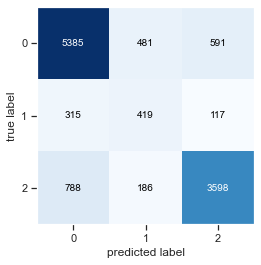

In [16]:
cm = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm)
plt.show()

Our 3-class dataframe does not fit well to previous binary model. It is highly overfit. To handle with overfit we will try to LGBM and XGBoost with parameters.

**LGBM**

[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: maximize
[LightGBM] [Warning] num_iterations is set=100, nrounds=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: maximize
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1153
[LightGBM] [Info] Number of d

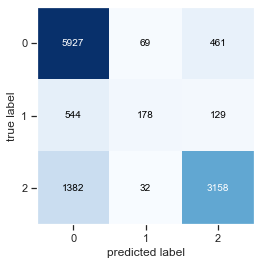

In [17]:
#seting model
lgbm = LGBMClassifier(booster = 'gbtree', nrounds = 100, maximize = False,eta = .1,max_depth = 10, colsample_bytree = .4,learning_rate = 0.1,max_delta_step=1)

#sending everthing in pipe
pipe = make_pipeline(preprocessor,lgbm)
pipe.fit(X_train, y_train)

# predictions on train set
y_pred = pipe.predict(X_train)

# predictions on test set
y_pred_test = pipe.predict(X_test)

print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")

#confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm)
plt.show()

LightGBM did good job about handling overfit but our accuracy is very low. So, we will continue to XGBoost.

**XGBoost**

Accuracy:
TRAIN: 0.8297558922558923
TEST: 0.7951178451178451

Balanced Accuracy:
TRAIN: 0.658789681225371
TEST: 0.6227623809659145


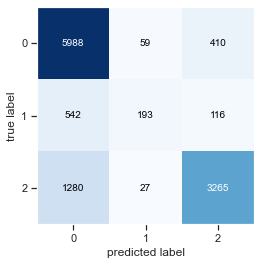

In [18]:
xgb = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx',
                      num_class = 3, maximize = False, eval_metric = 'merror', eta = .1,
                      max_depth = 10, colsample_bytree = .4, n_jobs = -1,learning_rate = 0.05)

pipe = make_pipeline(preprocessor,xgb)
pipe.fit(X_train, y_train)


# make predictions on training set
y_pred = pipe.predict(X_train)

# make predictions on test set
y_pred_test = pipe.predict(X_test)

# to print the results in good way
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")


cm = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm)
plt.show()

XGBoost also gave overfit results. With playing around parameters we got closer the train- test balanced accuracy results, but stil it is overfit and there are big difference between accuracy and balanced accuracy. Also, 62% is very less. From this information, we understand that we need to solve our imbalanced class problem. To do this, there are some ways. We can set class weight as balanced in Random Forest which we have already done. The other common solution is to resampling imbalanced data. There are two main ways; over-sampling and under-sampling. One of our labels is really insufficient. So, we will use over sampling technique. It tries to balance target with increasing the number of the rare samples. To protect our data from abundant samples, new rare samples must be generated by using techniques as repetition, bootstrapping or SMOTE (Synthetic Minority Over-Sampling Technique).

**SMOTE**

To use SMOTE with scaler and encoder takes too much time. So, we will encode and scale our dataframe and change it. To protect the original one, we assign it to new df.

In [19]:
df4=df1.copy() # assign to protect original one 

In [20]:
# encoding categorical columns
encoder = TargetEncoder()

for c in cat_col:
    df4[str(c) + '_encoded'] = encoder.fit_transform(df4[c].values, df4[target])
    df4.drop(columns=c, inplace=True) 

In [21]:
# scaling numerical columns

scaler = preprocessing.RobustScaler()


def scaleColumns(df, num_col):
    for col in num_col:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df4[col])),columns=[col])
    return df

scaled_df = scaleColumns(df4,[num_col])

In [22]:
# assign X and y
used_cols = [c for c in scaled_df.columns.tolist() if c not in [target]]
X=scaled_df[used_cols]
y=scaled_df[target]

In [23]:
# making over-sampling 

smt = SMOTE(sampling_strategy = 'auto', n_jobs = -1)

X_sampled, y_sample = smt.fit_resample(X, y)

print(y.value_counts())

y_sampled = pd.Series(y_sample) # converting from array to np.series to see value_counts

print(y_sampled.value_counts())

status_group
0    32259
2    22824
1     4317
Name: count, dtype: int64
status_group
0    32259
2    32259
1    32259
Name: count, dtype: int64


Our target was made baanced with taking random samples.

In [24]:

#splitting train-test balanced target data
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)

In [25]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# Define the XGBClassifier
xgb_model = XGBClassifier(
    objective='multi:softmax',
    booster='gbtree',
    num_class=3,
    maximize=False,
    eval_metric='merror',
    eta=0.1,
    max_depth=16,
    colsample_bytree=0.4,
    n_jobs=-1,
    learning_rate=0.1,
    early_stopping_rounds=10
)

# Fit the model on the training data
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

# Make predictions
y_pred = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# Print the results
print("Accuracy:")
print("=" * len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

print("\nBalanced Accuracy:")
print("=" * len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")


[0]	validation_0-merror:0.24871
[1]	validation_0-merror:0.21105
[2]	validation_0-merror:0.20268
[3]	validation_0-merror:0.19054
[4]	validation_0-merror:0.19136
[5]	validation_0-merror:0.18878
[6]	validation_0-merror:0.18614
[7]	validation_0-merror:0.18387
[8]	validation_0-merror:0.18258
[9]	validation_0-merror:0.18025
[10]	validation_0-merror:0.18051
[11]	validation_0-merror:0.17943
[12]	validation_0-merror:0.17865
[13]	validation_0-merror:0.17664
[14]	validation_0-merror:0.17467
[15]	validation_0-merror:0.17276
[16]	validation_0-merror:0.17261
[17]	validation_0-merror:0.17183
[18]	validation_0-merror:0.17008
[19]	validation_0-merror:0.16889
[20]	validation_0-merror:0.16832
[21]	validation_0-merror:0.16625
[22]	validation_0-merror:0.16532
[23]	validation_0-merror:0.16543
[24]	validation_0-merror:0.16501
[25]	validation_0-merror:0.16522
[26]	validation_0-merror:0.16367
[27]	validation_0-merror:0.16341
[28]	validation_0-merror:0.16284
[29]	validation_0-merror:0.16238
[30]	validation_0-me

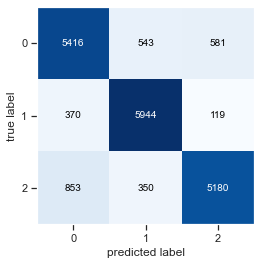

In [26]:
cm = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm)
plt.show()

With smote, we found best test balanced accuracy. 85% is a enough good result for the first submission. From the confusion matrix, it is seen that splits are clear but not exact. We will work on overfitting problem more with tuning the parametes as future plan. 

**Conclusion**

All of these 4 models, XGBoost is best when we use it with SMOTE. So, our new and decided model is XGBoost with SMOTE. With 85% accuracy, we can predict the functionality of the wells.